In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import collections 
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd
import numpy as np

# Load the datasets
train_df = pd.read_csv('raw182_Training_Relabeled_Auto_25.csv')
test_df = pd.read_csv('raw91_Testing_Relabeled_Auto_25.csv')

In [3]:
n = 40
X_train, y_train = [], []

for i in range(0, len(train_df) - n):
    temp = []

    temp.append(train_df[' ms_accelerometer_x'][i : i + n])
    temp.append(train_df[' ms_accelerometer_y'][i : i + n])
    temp.append(train_df[' ms_accelerometer_z'][i : i + n])

    cnt = collections.Counter(train_df['outcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]

    if num_fall == 25:
        y_train.append(1)
    else:
        y_train.append(0)

    X_train.append(temp)

In [4]:
n = 40
X_test_adl, X_test_fall, y_test_adl, y_test_fall = [], [], [], []

for i in range(0, len(test_df) - n):
    temp = []

    temp.append(test_df[' ms_accelerometer_x'][i : i + n])
    temp.append(test_df[' ms_accelerometer_y'][i : i + n])
    temp.append(test_df[' ms_accelerometer_z'][i : i + n])

    cnt = collections.Counter(test_df['outcome'][i : i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]

    if num_fall == 25:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

In [5]:
print(len(y_test_fall))
print(len(y_test_adl))

1456
15733


In [6]:
# to keep the balance between ADL and FALL data, used only part of ADL data

X_test_adl = X_test_adl[:3216]
y_test_adl = y_test_adl[:3216]

y_test = y_test_adl + y_test_fall
X_test = X_test_adl + X_test_fall

In [7]:
print('length of test data', len(X_test))

length of test data 4672


In [8]:
print('train data adl and fall ratio')
print('--------------------------------')
cnt_train = collections.Counter(y_train)
print('train data adl ratio: ', cnt_train[0])
print('train data fall ratio: ', cnt_train[1])
print('--------------------------------')

cnt_test = collections.Counter(y_test)
print('test data adl ratio: ', cnt_test[0])
print('test data fall ratio: ', cnt_test[1])

train data adl and fall ratio
--------------------------------
train data adl ratio:  31068
train data fall ratio:  2912
--------------------------------
test data adl ratio:  3216
test data fall ratio:  1456


In [9]:
import torch
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=n_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = self.init_hidden(x)
        out, hn = self.gru(x, h0)
        out = self.fc(self.relu(out[:, -1]))
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        return h0

In [10]:
X_train = np.asarray(X_train).reshape(-1, 40, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_test = np.asarray(X_test).reshape(-1, 40, 3)
y_test = np.asarray(y_test).reshape(-1, )

In [11]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [13]:
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

batch_size = 128

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True, batch_size=batch_size)

valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    shuffle=True, batch_size=batch_size)

test_data =TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True, batch_size=batch_size)

In [14]:
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingLR as cosine
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR
import time

In [15]:
# Model parameters
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 10
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

# Instantiate the model on CPU
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
print(model)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sched = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=lr/10)  # Using CosineAnnealingLR
epoch_times = []

GRUNet(
  (gru): GRU(3, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)


In [31]:
# Training loop with accuracy computation and validation
epoch_times = []
train_losses = []
train_accuracies = []

for epoch in range(n_epochs):
    model.train()
    epoch_start_time = time.time()
    correct = 0
    total = 0
    epoch_loss = 0.0

    # Training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.float())  # Ensure data is converted to float
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    # Compute training loss and accuracy
    train_losses.append(epoch_loss / len(train_loader.dataset))
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # Step scheduler
    sched.step()

    # Compute epoch time
    epoch_end_time = time.time()
    epoch_times.append(epoch_end_time - epoch_start_time)

    # Print training progress
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.2%}, Time: {epoch_end_time - epoch_start_time:.2f} sec")

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for val_data, val_target in valid_loader:
            val_output = model(val_data.float())
            val_loss += criterion(val_output, val_target).item() * val_data.size(0)
            _, val_predicted = torch.max(val_output.data, 1)
            val_total += val_target.size(0)
            val_correct += (val_pre`dicted == val_target).sum().item()

    # Compute validation loss and accuracy
    val_loss = val_loss / len(valid_loader.dataset)
    val_accuracy = val_correct / val_total

    # Print validation metrics
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

    # Optionally, you can add code here to save the best model based on validation accuracy

print(f"Total Training Time: {sum(epoch_times):.2f} seconds")


Epoch [1/10], Loss: 0.3322, Accuracy: 91.42%, Time: 174.05 sec
Validation Loss: 0.2837, Validation Accuracy: 91.55%
Epoch [2/10], Loss: 0.2433, Accuracy: 91.69%, Time: 168.64 sec
Validation Loss: 0.1810, Validation Accuracy: 92.64%
Epoch [3/10], Loss: 0.1596, Accuracy: 93.65%, Time: 168.75 sec
Validation Loss: 0.1205, Validation Accuracy: 94.94%
Epoch [4/10], Loss: 0.1034, Accuracy: 95.96%, Time: 170.66 sec
Validation Loss: 0.0973, Validation Accuracy: 96.12%
Epoch [5/10], Loss: 0.0865, Accuracy: 96.70%, Time: 165.79 sec
Validation Loss: 0.0755, Validation Accuracy: 97.06%
Epoch [6/10], Loss: 0.0735, Accuracy: 97.24%, Time: 169.91 sec
Validation Loss: 0.0686, Validation Accuracy: 97.47%
Epoch [7/10], Loss: 0.0664, Accuracy: 97.54%, Time: 170.51 sec
Validation Loss: 0.0616, Validation Accuracy: 97.88%
Epoch [8/10], Loss: 0.0629, Accuracy: 97.69%, Time: 165.80 sec
Validation Loss: 0.0601, Validation Accuracy: 97.91%
Epoch [9/10], Loss: 0.0614, Accuracy: 97.73%, Time: 162.28 sec
Validatio

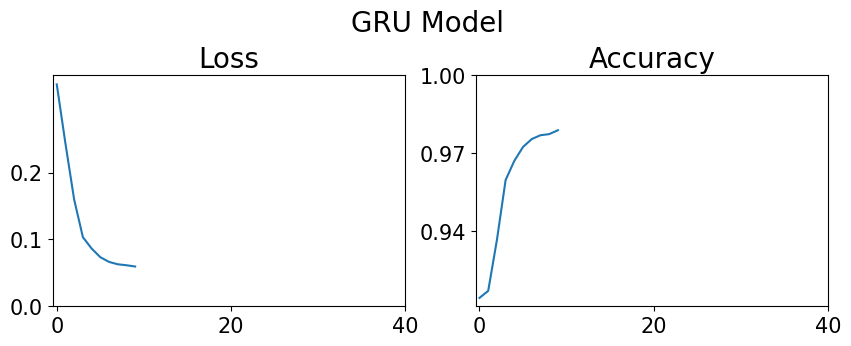

In [33]:
plt.figure(figsize=(10, 3))
plt.suptitle('GRU Model', fontsize=20, y=1.1)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses)), train_losses)
plt.yticks([0.0, 0.1, 0.2], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Loss', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.yticks([0.94, 0.97, 1.0], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Accuracy',fontsize=20)
plt.subplots_adjust(hspace=1)

plt.show()

In [34]:
# evaluation with test dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

targets = []
preds = []
correct = 0

# Evaluate on test data
with torch.no_grad():
    for X, y in test_loader:
        output = model(X.float())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

        targets += list(y.numpy())
        preds += list(pred.numpy())

# Calculate test accuracy
test_acc = 100. * correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.2f}%")

# Calculate and print confusion matrix
confusion_mtx = confusion_matrix(targets, preds)
print("Confusion Matrix:")
print(confusion_mtx)

# Optionally, you can print classification report
print("Classification Report:")
print(classification_report(targets, preds))


Test Accuracy: 94.14%
Confusion Matrix:
[[3138   78]
 [ 196 1260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3216
           1       0.94      0.87      0.90      1456

    accuracy                           0.94      4672
   macro avg       0.94      0.92      0.93      4672
weighted avg       0.94      0.94      0.94      4672



In [35]:
from sklearn.metrics import f1_score, recall_score, precision_score

print(f1_score(targets, preds))
print(recall_score(targets, preds))
print(precision_score(targets, preds))

0.901932712956335
0.8653846153846154
0.9417040358744395
